Before you turn in the homework, make sure everything runs as expected. To do so, select **Kernel**$\rightarrow$**Restart & Run All** in the toolbar above.  Remember to submit both on **DataHub** and **Gradescope**.

Please fill in your name and include a list of your collaborators below.

---

# Project 2: NYC Taxi Rides
# Part 2: EDA, Visualization, Feature Engineering

In this part, we will conduct EDA on the NYC Taxi dataset that we cleaned and train/validation split in part 1. We will also guide you through the engineering of some features that hopefully will help our model to accurately understand the data.


# Imports

Let us start by loading the Python libraries and custom tools we will use in this part.  

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

sns.set(style="whitegrid", palette="muted")
%matplotlib inline

## Loading & Formatting data

The following code loads the data into a pandas DataFrame.

In [3]:
# Run this cell to load the data. 
data_file = Path("data/part1", "cleaned_data.hdf")
train_df = pd.read_hdf(data_file, "train")

In [4]:
train_df.head()

,record_id,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,...,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,duration
16434,8614300,2,2016-01-21 17:37:12,2016-01-21 18:37:56,2,10.89,-73.863403,40.769432,1,N,...,40.688210,1,41.5,1.0,0.5,6.00,0.0,0.3,49.30,3644.0
21929,7230200,2,2016-01-29 23:22:26,2016-01-29 23:31:23,2,1.00,-74.008087,40.739365,1,N,...,40.729271,1,7.0,0.5,0.5,1.66,0.0,0.3,9.96,537.0
3370,9830300,2,2016-01-05 18:50:16,2016-01-05 18:56:00,2,0.56,-73.972923,40.755650,1,N,...,40.758469,1,5.0,1.0,0.5,1.00,0.0,0.3,7.80,344.0
21975,7251500,2,2016-01-30 00:14:34,2016-01-30 00:47:13,1,6.65,-73.992027,40.718662,1,N,...,40.661118,1,25.5,0.5,0.5,2.68,0.0,0.3,29.48,1959.0
13758,6168000,1,2016-01-18 13:25:24,2016-01-18 13:38:51,1,2.10,-73.953125,40.784538,1,N,...,40.760792,2,11.5,0.0,0.5,0.00,0.0,0.3,12.30,807.0


## 1: Data Overview 

As a reminder, the raw taxi data contains the following columns:
- `recordID`: primary key of this database
- `VendorID`: a code indicating the provider associated with the trip record
- `passenger_count`: the number of passengers in the vehicle (driver entered value)
- `trip_distance`: trip distance
- `tpep_dropoff_datetime`: date and time when the meter was engaged
- `tpep_pickup_datetime`: date and time when the meter was disengaged
- `pickup_longitude`: the longitude where the meter was engaged
- `pickup_latitude`: the latitude where the meter was engaged
- `dropoff_longitude`: the longitude where the meter was disengaged
- `dropoff_latitude`: the latitude where the meter was disengaged
- `duration`: duration of the trip in seconds
- `payment_type`: the payment type
- `fare_amount`: the time-and-distance fare calculated by the meter
- `extra`: miscellaneous extras and surcharges
- `mta_tax`: MTA tax that is automatically triggered based on the metered rate in use	
- `tip_amount`: the	amount of credit card tips, cash tips are not included
- `tolls_amount`: amount paid for tolls
- `improvement_surcharge`: fixed fee
- `total_amount`: total amount paid by passengers, cash tips are not included

Let us take a closer look at the target `duration` variable. In the cell below, we plot its distribution using `sns.distplot`. This should give us an idea about whether we have some outliers in our data.

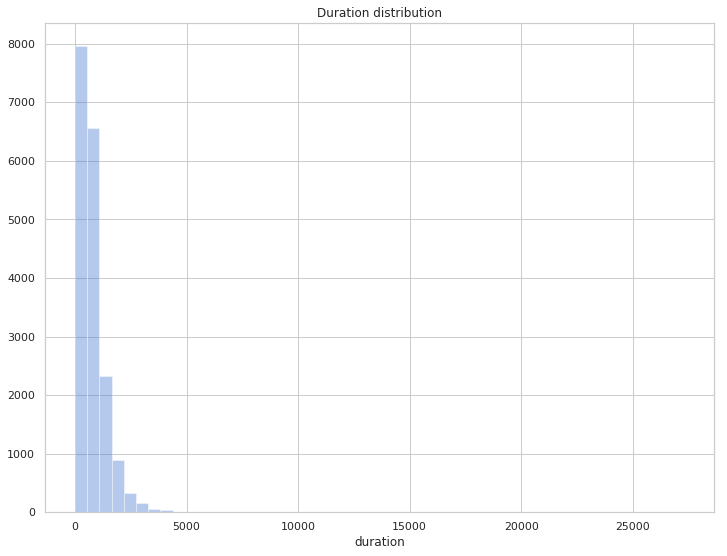

In [5]:
fig, ax = plt.subplots(figsize=(12, 9))

# Plot the distribution of duration using sns.distplot
# You can fill `ax=ax` to sns.distplot to plot in the ax object created above

sns.distplot(train_df['duration'], ax=ax, kde=False)

plt.title('Duration distribution');

As expected for a positive valued variable, we observe a skewed distribution. Note that we seem to have a handful of very long trips within our data. Use an appropriate data transformation to squeeze this highly-skewed distribution. Plot a `sns.distplot` of the transformed duration data for `train_df`.

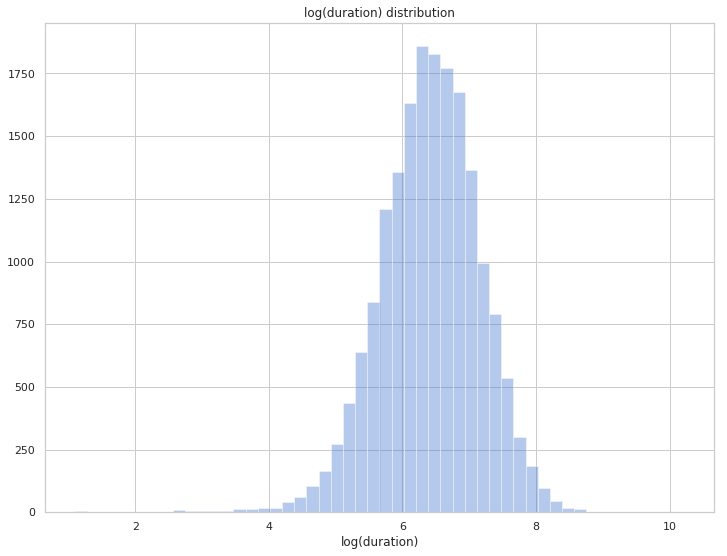

In [6]:
fig, ax = plt.subplots(figsize=(12, 9))

# Use a log transformation to squeeze the distribution
# You can add + 1 to all values before taking the log to handle possible 0 values for distribution

sns.distplot(np.log(train_df['duration'] + 1),
             ax=ax,
             axlabel='log(duration)',
             kde=False)

plt.title('log(duration) distribution');

After transforming our data, we should immediately observe that we are dealing with what seems to be log-normal distribution for the target variable `duration`. We can see the behavior of shorter rides better, whereas before they were lumped in a bar near 0. This is a nice result, since it can facilitate modeling later. 

**Note:** Keep in mind that we want to avoid peeking at our validation data because it may introduce bias. Therefore, we will be focusing on analyzing the training data for the remainder of this notebook.

## 2: Date Analysis

In order to understand the general pattern/trends of our taxi ride data, we will plot the number of taxi rides requested over time. Please run the following cell.

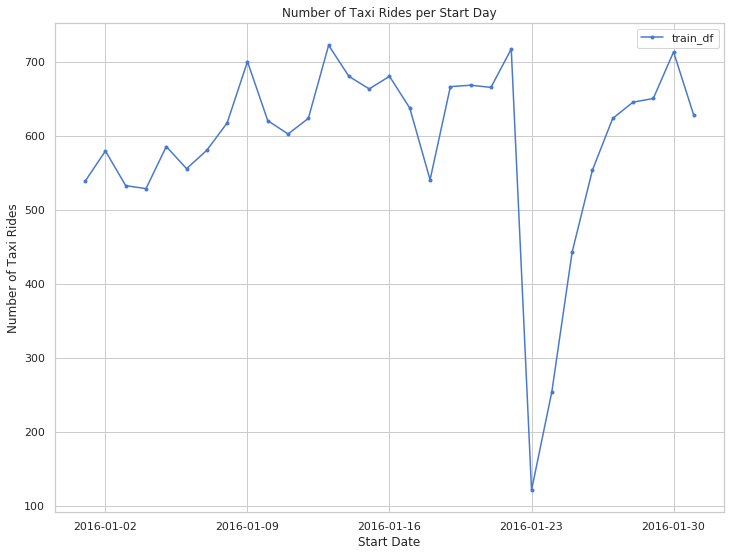

In [7]:
plt.figure(figsize=(12, 9))

# Make a temporary copy of our datasets
tmp_train = train_df.copy()
tmp_train['date'] = tmp_train['tpep_pickup_datetime'].dt.date
tmp_train = tmp_train.groupby('date').count()['pickup_longitude']

# Plot the temporal overlap
plt.plot(tmp_train, '.-', label='train_df')

plt.title('Number of Taxi Rides per Start Day')
plt.xlabel("Start Date")
plt.legend()
plt.ylabel('Number of Taxi Rides');

### Question 2a
Taking a closer look at the plot above, we notice a drastic drop in taxi rides towards the end of Janurary.
What is the date corresponding to the lowest number of taxi rides? Enter your answer as a string in the format MM-DD-YYYY.

In [8]:
lowest_rides_date = "01-23-2016"

#raise NotImplementedError()

print(lowest_rides_date)

01-23-2016


In [9]:
# Hidden test!

### Question 2b
What event could have caused this drop in taxi rides? Feel free to use Google.

In [10]:
q2b_answer = r"""

January 23, 2016 was the day of the largest blizzard to affect NYC since record keeping began in 1869. 
The snow was measured to be about 26.8 inches to 27.5 inches. This resulted in a drastic drop in taxi rides 
as people were stuck in doors due to the snow storm and people could not drive.  

"""


#raise NotImplementedError()

print(q2b_answer)



January 23, 2016 was the day of the largest blizzard to affect NYC since record keeping began in 1869. 
The snow was measured to be about 26.8 inches to 27.5 inches. This resulted in a drastic drop in taxi rides 
as people were stuck in doors due to the snow storm and people could not drive.  




## 3. Spatial/Locational Analysis

We are curious about the distribution of taxi pickup/dropoff coordinates. We also may be interested in observing whether this distribution changes as we condition of longer/shorter taxi rides. In the cells below, we will categorize our data into long and short rides based on duration. Then we will plot the latitude and longitude coordinates of rides conditioned on these categories.

First you may want to familiarize yourself with a [map of Manhattan](https://www.google.com/maps/place/Manhattan,+New+York,+NY/@40.7590402,-74.0394431,12z/data=!3m1!4b1!4m5!3m4!1s0x89c2588f046ee661:0xa0b3281fcecc08c!8m2!3d40.7830603!4d-73.9712488).

Here we split `train_df` into two data frames, one called `short_rides` and one called `long_rides`. `short_rides` should contain all rides less than or equal to 15 minutes and `long_rides` should contain rides more than 15 minutes. 

**Note:** We chose 15 minutes because the mean duration of a ride is roughly 700 seconds ~ 12 minutes. We then round up to the nearest nice multiple of 5. Note that you should adjust how you determine short/long rides and outliers when feature engineering.

In [11]:
short_rides = train_df[train_df["duration"] <= 900] # rides less than or equal to 15 mins
long_rides = train_df[train_df["duration"] > 900] # rides more than 15 minutes

In [12]:
assert len(short_rides) == 12830
assert len(long_rides) == 5524

Below we generate 4 scatter plots. The scatter plots are ordered as follows:

* ax1: plot the __start__ location of short duration rides
* ax2: plot the __start__ location of long duration rides
* ax3: plot the __end__ location of short duration rides
* ax4: plot the __end__ location of long duration rides

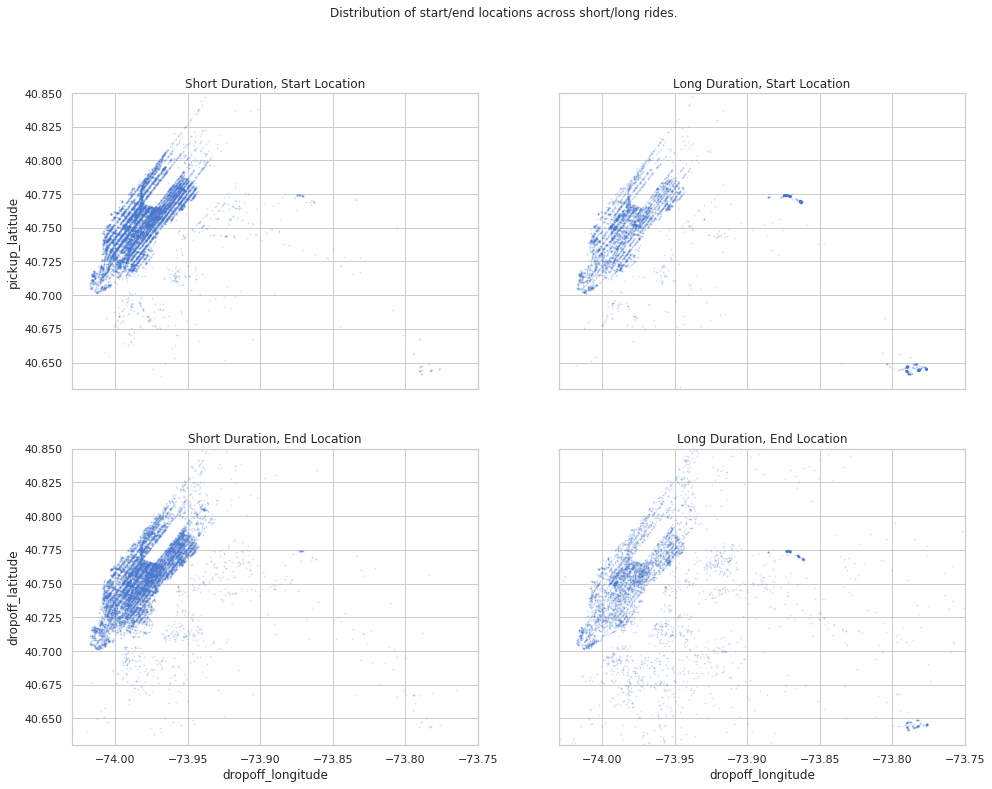

In [13]:
# Set random seed of reproducibility
random.seed(42)

# City boundaries
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

# Define figure
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows = 2, figsize=(16, 12), sharex=True, sharey=True)
alpha = 0.15 # make sure to include these as an argument
s = 1 # make sure to include this as an argument

short_rides.plot(kind = "scatter", x = "pickup_longitude", y = "pickup_latitude",
                     ax = ax1, alpha = alpha, s = s, title='Short Duration, Start Location')
long_rides.plot(kind = "scatter", x = "pickup_longitude", y = "pickup_latitude",
                    ax = ax2, alpha = alpha, s = s, title='Long Duration, Start Location')
short_rides.plot(kind = "scatter", x = "dropoff_longitude", y = "dropoff_latitude",
                     ax = ax3, alpha = alpha, s = s , title='Short Duration, End Location')
long_rides.plot(kind = "scatter", x = "dropoff_longitude", y = "dropoff_latitude",
                    ax = ax4, alpha = alpha, s = s, title='Long Duration, End Location')


fig.suptitle('Distribution of start/end locations across short/long rides.')


plt.ylim(city_lat_border)
plt.xlim(city_long_border);

### Question 3a

What do the plots above look like? 

In particular:
- Find what the following circled regions correspond to:
<img src="figs/nyc_locations.png" width="50%"></img>

**Hint: Here is a [page](https://www.google.com/maps/place/Manhattan,+New+York,+NY/@40.7590402,-74.0394431,12z/data=!3m1!4b1!4m5!3m4!1s0x89c2588f046ee661:0xa0b3281fcecc08c!8m2!3d40.7830603!4d-73.9712488) that may be useful.**

In [14]:
q3a_answer = r"""

These scatter plots represent maps of a part of New York. The figure shows the shape of the region we are interested in which 
are Manhattan (largest circled region), Central Park (rectangular circled region), and LaGuardia (smallest circled region).
The figures show the shape of the cities / boroughs of NY that we are interested in analyzing and learning about, as well as
the longitude and latitude respective to pickup and dropoff locations. To make things more organized and easy to see and understand 
the information has been clustered into corresponding figures -- 'Short Duration, Start Location'; 'Short Duration, End Location'; 'Long Duration, Start Location'; 'Long Duration, End Location'. 

"""


#raise NotImplementedError()

print(q3a_answer)



These scatter plots represent maps of a part of New York. The figure shows the shape of the region we are interested in which 
are Manhattan (largest circled region), Central Park (rectangular circled region), and LaGuardia (smallest circled region).
The figures show the shape of the cities / boroughs of NY that we are interested in analyzing and learning about, as well as
the longitude and latitude respective to pickup and dropoff locations. To make things more organized and easy to see and understand 
the information has been clustered into corresponding figures -- 'Short Duration, Start Location'; 'Short Duration, End Location'; 'Long Duration, Start Location'; 'Long Duration, End Location'. 




### Question 3b
In each scatter plot above, why are there no points contained within the small rectangular region (towards the top left between the blue points)? Could this be an error/mistake in our data?

In [15]:
q3b_answer = r"""

In our scatterplots above, ther are no points contained within the smaller rectangular region (towards the top left
between the blue points) because that area is Central Park and you cannot drive there. Therefore, it makes sense that
there are no points there as taxis and other transportation services cannot go inside of the park. 

"""


#raise NotImplementedError()


print(q3b_answer)



In our scatterplots above, ther are no points contained within the smaller rectangular region (towards the top left
between the blue points) because that area is Central Park and you cannot drive there. Therefore, it makes sense that
there are no points there as taxis and other transportation services cannot go inside of the park. 




### Question 3c
What observations/conclusions do you make based on the scatter plots above? In particular, how are trip duration and pickup/dropoff location related?

In [16]:
q3c_answer = r"""

Based on the scatter plots above, we are able to tell that the majority of short trips (with respect to duration) 
start and end in Manhattan, while the majority of long trips (with respect to duration) end at LaGuardia. For long trips,
there are many rides starting in Manhattan as well as LaGuardia, but what really stands out is the difference between 
short and long trips. The difference is that majority of short trips are within Manhattan (starting and ending there), 
while the majority of long trips are from Manhattan to LaGuardia (starting in Manhattan and ending at LaGuardia). This is 
likely due to many rides going from Manhattan to LaGuardia Airport. 

"""


#raise NotImplementedError()

print(q3c_answer)



Based on the scatter plots above, we are able to tell that the majority of short trips (with respect to duration) 
start and end in Manhattan, while the majority of long trips (with respect to duration) end at LaGuardia. For long trips,
there are many rides starting in Manhattan as well as LaGuardia, but what really stands out is the difference between 
short and long trips. The difference is that majority of short trips are within Manhattan (starting and ending there), 
while the majority of long trips are from Manhattan to LaGuardia (starting in Manhattan and ending at LaGuardia). This is 
likely due to many rides going from Manhattan to LaGuardia Airport. 




This confirms that the trips are localized in NYC, with a very strong concentration in Manhattan **and** on the way to LaGuardia Airport. This might give you ideas of relevant features for feature engineering.  

Another way to visualize ride coordinates is using a **heat map** (this also helps us avoid overplotting). The following plots count the number of trips for NYC neighborhoods and areas, plotting with the `geopandas` package and theses [shapefiles](https://geo.nyu.edu/catalog/nyu_2451_36743) (do not mind the values on the colorbar). If you are curious about how to create the figures below, feel free to check out [`geopandas`](http://geopandas.org/).

![neighborhoods](figs/chloro_NY_neighborhoods.png)
![neighborhoods](figs/chloro_NY_taxi_zones.png)

## 4: Temporal features
We can utilize the `start_timestamp` column to design a lot of interesting features.

We implement the following temporal (related to time) features using the `add_time_columns` function below.
- `month` derived from `start_timestamp`.
- `week_of_year` derived from `start_timestamp`.
- `day_of_month` derived from `start_timestamp`.
- `day_of_week` derived from `start_timestamp`.
- `hour` derived from `start_timestamp`.
- `week_hour` derived from `start_timestamp`.

**Note 1**: You can use the `dt` attribute of the `start_timestamp` column to convert the entry into a `DateTime` object.

**Note 2**: We set `df.is_copy = False` to explicitly write back to the original dataframe, `df`, that is being passed into the `add_time_columns` function. Otherwise `pandas` will complain.

In [17]:
def add_time_columns(df):
    """
    Add temporal features to df
    """
    df.is_copy = False 
    df.loc[:, 'month'] = df['tpep_pickup_datetime'].dt.month
    df.loc[:, 'week_of_year'] = df['tpep_pickup_datetime'].dt.weekofyear
    df.loc[:, 'day_of_month'] = df['tpep_pickup_datetime'].dt.day
    df.loc[:, 'day_of_week'] = df['tpep_pickup_datetime'].dt.dayofweek
    df.loc[:, 'hour'] = df['tpep_pickup_datetime'].dt.hour
    df.loc[:, 'week_hour'] = df['tpep_pickup_datetime'].dt.weekday * 24 + df['hour']
 
    # No real need to return here, but we harmonize with remove_outliers for later pipelinezation
    return df

In [18]:
# Note that we are applying this transformation to train_df, short_rides and long_rides
train_df = add_time_columns(train_df)
short_rides = add_time_columns(short_rides)
long_rides = add_time_columns(long_rides)

/srv/conda/envs/data100/lib/python3.6/site-packages/pandas/core/generic.py:4388: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/srv/conda/envs/data100/lib/python3.6/site-packages/pandas/core/generic.py:4389: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


In [19]:
train_df[['month', 'week_of_year', 'day_of_month', 'day_of_week', 'hour', 'week_hour']].head()

,month,week_of_year,day_of_month,day_of_week,hour,week_hour
16434,1,3,21,3,17,89
21929,1,4,29,4,23,119
3370,1,1,5,1,18,42
21975,1,4,30,5,0,120
13758,1,3,18,0,13,13


Your `train_df.head()` should look like this, although the ordering of the data in `id` might be different:
![time_columns](figs/time_columns.png)

In [20]:
time_columns = ['month',
                'week_of_year',
                'day_of_month',
                'day_of_week',
                'hour',
                'week_hour']


# Check columns were created
assert all(column in train_df.columns for column in time_columns)

# Check type
assert train_df[time_columns].dtypes.nunique() == 1

assert train_df[time_columns].dtypes.nunique() == 1

### Visualizing Temporal Features

### Question 4a
Let us now use the features we created to plot some histograms and visualize patterns in our dataset. We will analyze the distribution of the number of taxi rides across months and days of the week. This can help us visualize and understand patterns and trends within our data.

This is a open ended question. Create 2 plots that visualize temporal information from our dataset. At least one of them must visualize the hour of each day. Aside from that you can use any column from `time_columns`. 

You can use the same column multiple times, but if the plots are redundant you will not receive full credit. This will be graded based on how informative each plot is and how "good" the visualization is (remember what good/bad visualizations look like for different kinds of data!).  

#### Visualization 1

In [21]:
tmp_train

date
2016-01-01    539
2016-01-02    580
2016-01-03    533
2016-01-04    529
2016-01-05    586
2016-01-06    556
2016-01-07    581
2016-01-08    618
2016-01-09    701
2016-01-10    621
2016-01-11    603
2016-01-12    624
2016-01-13    723
2016-01-14    681
2016-01-15    664
2016-01-16    681
2016-01-17    638
2016-01-18    541
2016-01-19    667
2016-01-20    669
2016-01-21    666
2016-01-22    718
2016-01-23    121
2016-01-24    254
2016-01-25    443
2016-01-26    554
2016-01-27    624
2016-01-28    646
2016-01-29    651
2016-01-30    714
2016-01-31    628
Name: pickup_longitude, dtype: int64

In [22]:
short_rides.head()
long_rides.head()

,record_id,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,...,tolls_amount,improvement_surcharge,total_amount,duration,month,week_of_year,day_of_month,day_of_week,hour,week_hour
16434,8614300,2,2016-01-21 17:37:12,2016-01-21 18:37:56,2,10.89,-73.863403,40.769432,1,N,...,0.00,0.3,49.30,3644.0,1,3,21,3,17,89
21975,7251500,2,2016-01-30 00:14:34,2016-01-30 00:47:13,1,6.65,-73.992027,40.718662,1,N,...,0.00,0.3,29.48,1959.0,1,4,30,5,0,120
2659,1073300,1,2016-01-04 19:55:37,2016-01-04 20:11:26,1,2.70,-73.955994,40.775543,1,N,...,0.00,0.3,15.80,949.0,1,1,4,0,19,19
1132,563500,2,2016-01-02 17:37:42,2016-01-02 18:26:44,1,16.09,-73.803864,40.649147,2,N,...,5.54,0.3,70.01,2942.0,1,53,2,5,17,137
15594,8237700,1,2016-01-20 18:11:18,2016-01-20 18:30:09,1,1.80,-73.967278,40.763248,1,N,...,0.00,0.3,17.15,1131.0,1,3,20,2,18,66


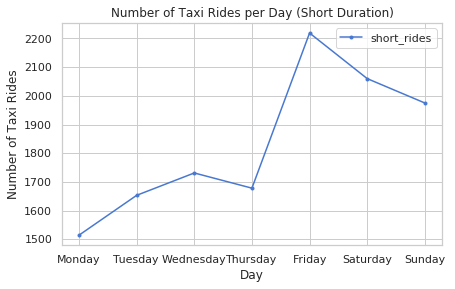

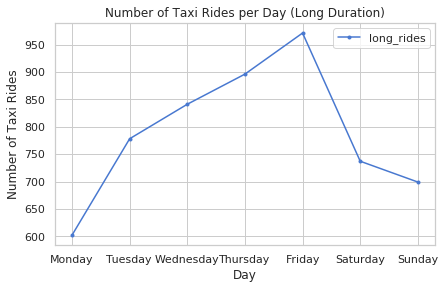

In [23]:
# Visualization 1
# distribution of the number of taxi rides across days of the week
# so we may be able to conclude what days of the week there are more or less rides 

#short duration 
plt.figure(figsize=(15, 9))
plt.subplot(221)

# Make a temporary copy of our datasets
tmp_short = short_rides.copy()
tmp_short = tmp_short.groupby('day_of_week').count()['pickup_longitude']
tmp_short #Monday(0), Tuesday(1), Wednesday(2), Thursday(3), Friday(4), Saturday(5), Sunday(6) 

# Plot the temporal overlap
plt.plot(tmp_short, '.-', label='short_rides')
plt.xticks([0, 1, 2, 3, 4, 5, 6], ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])

plt.title('Number of Taxi Rides per Day (Short Duration)')
plt.xlabel("Day")
plt.legend()
plt.ylabel('Number of Taxi Rides');


#long duration 
plt.figure(figsize=(15, 9))
plt.subplot(222)

# Make a temporary copy of our datasets
tmp_long = long_rides.copy()
tmp_long = tmp_long.groupby('day_of_week').count()['pickup_longitude']
tmp_long #Monday(0), Tuesday(1), Wednesday(2), Thursday(3), Friday(4), Saturday(5), Sunday(6) 

# Plot the temporal overlap
plt.plot(tmp_long, '.-', label='long_rides')
plt.xticks([0, 1, 2, 3, 4, 5, 6], ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])

plt.title('Number of Taxi Rides per Day (Long Duration)')
plt.xlabel("Day")
plt.legend()
plt.ylabel('Number of Taxi Rides');

#raise NotImplementedError()

#### Visualization 2

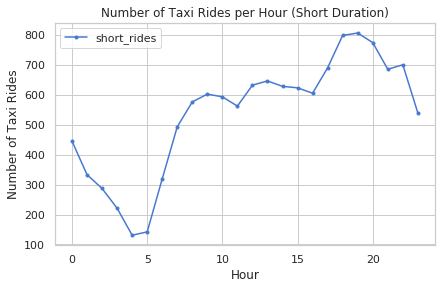

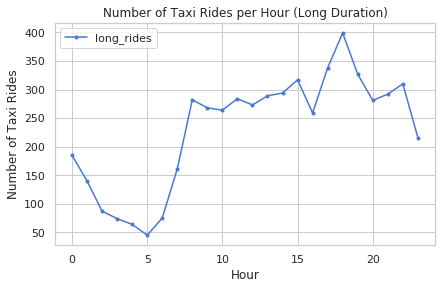

In [24]:
# Visualization 2
# visualize the number of taxis across hours per day 
# which hour is most popular / busy for taxis

plt.figure(figsize=(15, 9))
plt.subplot(221)

# Make a temporary copy of our datasets
#short rides 
tmp_short = short_rides.copy()
tmp_short = tmp_short.groupby('hour').count()['pickup_longitude']
tmp_short #0: 12am, 1: 1am, ..., 15: 3pm, 20: 8pm, etc. 

# Plot the temporal overlap
plt.plot(tmp_short, '.-', label='short_rides')

plt.title('Number of Taxi Rides per Hour (Short Duration)')
plt.xlabel("Hour")
plt.legend()
plt.ylabel('Number of Taxi Rides');


#Long Rides
plt.figure(figsize=(15, 9))
plt.subplot(222)

# Make a temporary copy of our datasets
tmp_long = long_rides.copy()
tmp_long = tmp_long.groupby('hour').count()['pickup_longitude']
tmp_long #0: 12am, 1: 1am, ..., 15: 3pm, 20: 8pm, etc. 

# Plot the temporal overlap
plt.plot(tmp_long, '.-', label='long_rides')

plt.title('Number of Taxi Rides per Hour (Long Duration)')
plt.xlabel("Hour")
plt.legend()
plt.ylabel('Number of Taxi Rides');

#raise NotImplementedError()

### Question 4b
Briefly explain for each plot
1. What feature you're visualization
2. Why you chose this feature
3. Why you chose this visualization method

In [25]:
q4b_answer = r"""

The first plot:
1. Here, we are visualizing the distribution of the number of taxi rides accross the days of the week (Monday through Sunday, or 0-6).
2. I chose to explore this feature becasue it may be helpful in future analysis. It may be helpful to understand the distribution
of taxi rides per day, as we can visually see which days are more popular / busy for taxi drivers. We can see whether more taxis 
are being used on weekdays or weekends, or which day of the week has a higher number of taxi rides. This is all useful information to have.
3. I chose this visualization method, line plot, because it is simple, easy to read and understand, and effective. The clearly
labeled axes make it easy to see what we are inspecting. The line effectively shows the distribution of the number of taxi rides 
per day of the week, with points to show the exact amount of rides for each day according to our training dataset. It is a 
simple yet effective visualization that works very well with the type of data we have and the features I chose to visualize.


The second plot:
1. Here, we are visualizing the distribution of the number of taxi rides accross the hours of the day (24 hours in a day, military time). 
2. I chose to explore this feature because it was required according to the problem statement, but I would have chosen to inspect it
regardless for other reasons. Visualizing the distribution of the number of taxi rides per hour (of a day) allows us to see what time of day
is most congested with traffic, has the highest number of taxi rides, and is the busiest / most popular time for taxi rides. This 
is useful information to have for future analyses, depending on our research question. 
3. My reasoning for why I chose this visualization method, line plot, is the same as what I wrote in regards to why I chose it for 
my first plot. Please see point 3 of my first plot explanation. 

For both of these plots, I subset them by long rides and short rides in order to understand these features better in terms of 
duration 

"""


#raise NotImplementedError()

print(q4b_answer)



The first plot:
1. Here, we are visualizing the distribution of the number of taxi rides accross the days of the week (Monday through Sunday, or 0-6).
2. I chose to explore this feature becasue it may be helpful in future analysis. It may be helpful to understand the distribution
of taxi rides per day, as we can visually see which days are more popular / busy for taxi drivers. We can see whether more taxis 
are being used on weekdays or weekends, or which day of the week has a higher number of taxi rides. This is all useful information to have.
3. I chose this visualization method, line plot, because it is simple, easy to read and understand, and effective. The clearly
labeled axes make it easy to see what we are inspecting. The line effectively shows the distribution of the number of taxi rides 
per day of the week, with points to show the exact amount of rides for each day according to our training dataset. It is a 
simple yet effective visualization that works very well with the t

### Question 4c

From the various plots above, what conclusions can you draw about the temporal aspects of our data? How does this relate to duration? 

In [26]:
q4c_answer = r"""

Above, I plotted the distribution of the number of taxi rides per day of the week as well as per hour of the day. 
From these plots, many conclusions may be drawn or give us an idea as to what further questions to ask and inspect, 
but let's focus on conclusions that can be drawn about the temporal aspects of our data. 

From the above plots, we can 
conclude that starting from Monday, the number of taxi rides increase with the highest peak on Friday, and then a decrease 
in rides during the weekend (Saturday, Sunday). Besides this general trend, we also see that Friday, Saturday, and Sunday
have the largest numbers of taxi rides with Monday at the lowest number and Wednesday and Thursday having about the same amount.
From this, we can conclude that Friday and the weekend are the most popular / busy day for taxi rides, and likeley the most
congested traffic-wise. Now, let's inspect the time of day. We see from the above plots that there is a decrease in the number
of taxi rides from 12am (0) to 5am (5). Then the number strictly increases to about 8am (8) and is fairly stagnant (a few
bumps of increase and decrease here and there) until 6pm (18) where there is an increase in rides. After this peak at 6pm
(the largest number of rides overall), the number of rides continues to decrease the rest of the day. 

Understanding these temporal aspects, specifically the number of taxi rides respective to day of the week and hour of the day,
helps us to learn a bit more about the duration of the trips. We can safely assume that the shorter trips are done during the 
popular periods of time (weekends and around 6pm, for example) as there is a higher number of trips at these times. The
less popular times of day and days of the week, likely correspond to longer trips that are being conducted. Longer trips 
mean lower number of rides. 

From the plots, we can see that there is a larger number of long rides and short rides occuring on Friday (that is
the peak of both plots), but that there are more long rides on weekdays than there are short rides on weekdays. As for 
hour of the day, it appears pretty similar regardless of duration of trip. There are very minor differences, with long rides 
being more specific/exact than short rides as can be seen by the shart peaks in long rides plot in comparison with short rides plot for hours. 

"""


#raise NotImplementedError()

print(q4c_answer)



Above, I plotted the distribution of the number of taxi rides per day of the week as well as per hour of the day. 
From these plots, many conclusions may be drawn or give us an idea as to what further questions to ask and inspect, 
but let's focus on conclusions that can be drawn about the temporal aspects of our data. 

From the above plots, we can 
conclude that starting from Monday, the number of taxi rides increase with the highest peak on Friday, and then a decrease 
in rides during the weekend (Saturday, Sunday). Besides this general trend, we also see that Friday, Saturday, and Sunday
have the largest numbers of taxi rides with Monday at the lowest number and Wednesday and Thursday having about the same amount.
From this, we can conclude that Friday and the weekend are the most popular / busy day for taxi rides, and likeley the most
congested traffic-wise. Now, let's inspect the time of day. We see from the above plots that there is a decrease in the number
of taxi rides from 

### Question 4d

Previously, we have analyzed the temporal features `hour` and `day_of_week` independently, but these features may in fact have a relationship between each other. Determining the extent to their relationship may be useful in helping us create new features in our model. Create a violin plot that displays distribution of rides over each hour per day of the week.

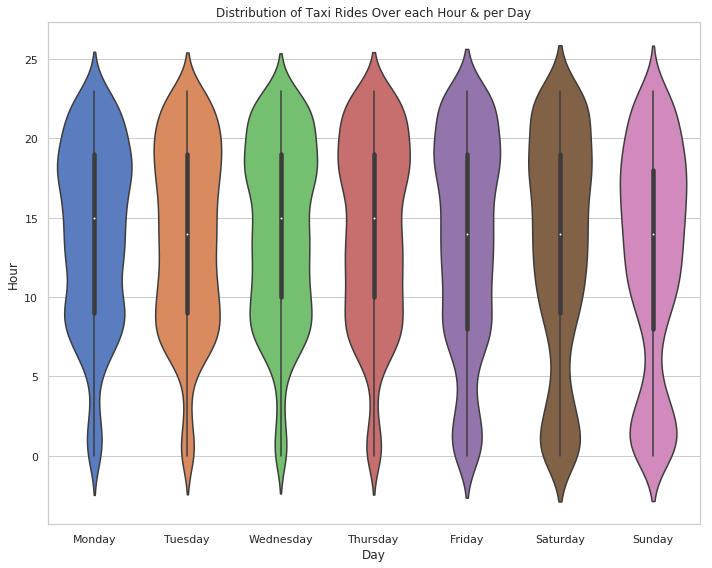

In [27]:
#TRAIN
fig, axes = plt.subplots(1, 1, figsize=(10, 8))
days_of_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

#a violin plot that displays distribution of rides over each hour per day of the week
sns.violinplot(x="day_of_week", y="hour", data=train_df)
plt.xticks([0, 1, 2, 3, 4, 5, 6], ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])

plt.title('Distribution of Taxi Rides Over each Hour & per Day')
plt.xlabel("Day")
plt.ylabel('Hour');

#raise NotImplementedError()

plt.tight_layout();

### Question 4e
Do you notice anything interesting about your visualization? How would you explain this plot to a lay person? What are the features/patterns of interest?

In [28]:
q4e_answer = r"""

The violin plot above shows the distribution of the number of taxi rides over each hour of the day segmented by day of 
the week. The x-axis represents the day of the week (Monday thorugh Sunday) and the y-axis represents each hour of the 
day (24 hours in a day). The violin shape for each day represents the distribution of the number of taxi rides per hour.
From the plot, we notice that, generally, the distribution appears to be similar for each day with slight variation. 
We see that Friday, Saturday, and Sunday has a higher number of rides than other days of the week in the early morning
(before 5am). The average is about the same for all days of the week, which is around the 15th hour (3pm). We notice that
there is slightly more taxi rides on Monday around the 20th hour compared to the other days of the week. 

What's interesting about this plot, is it confirms what we determined earlier in our analysis, which is that the weekend 
(Friday, Saturday, and Sunday), on average, has a higher number of taxi rides than other days of the week. The features/
patterns of interest are the relationship between hour and day of the week, distribution of rides per day, and 
distribution of rides per hour. 

"""


#raise NotImplementedError()

print(q4e_answer)



The violin plot above shows the distribution of the number of taxi rides over each hour of the day segmented by day of 
the week. The x-axis represents the day of the week (Monday thorugh Sunday) and the y-axis represents each hour of the 
day (24 hours in a day). The violin shape for each day represents the distribution of the number of taxi rides per hour.
From the plot, we notice that, generally, the distribution appears to be similar for each day with slight variation. 
We see that Friday, Saturday, and Sunday has a higher number of rides than other days of the week in the early morning
(before 5am). The average is about the same for all days of the week, which is around the 15th hour (3pm). We notice that
there is slightly more taxi rides on Monday around the 20th hour compared to the other days of the week. 

What's interesting about this plot, is it confirms what we determined earlier in our analysis, which is that the weekend 
(Friday, Saturday, and Sunday), on average, has a

## 5: Vendors

Recall that in Part 1, we found that there are only two unique vendors represented in the dataset. We may wonder if the vendor feature can be useful when trying to understand taxi ride duration.

### Question 5a
Visualize the VendorID feature. Create at least one plot that gives insight as to whether this feature would be useful or not in our model.

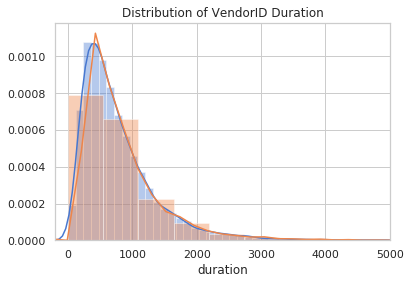

In [29]:
# Visualization (at least one plot)
#distribution for vendor 1 and vendor 2 

vendor_1 = train_df[train_df['VendorID'] == 1]
vendor_2 = train_df[train_df['VendorID'] == 2]
sns.distplot(vendor_1['duration'])
sns.distplot(vendor_2['duration'])
plt.title('Distribution of VendorID Duration')
plt.xlim(-200, 5000);

#raise NotImplementedError()

### Question 5b
Justify why you chose this visualization method and how it helps determine whether `vendor_id` is useful in our model or not.

In [30]:
q5b_answer = r"""

I chose to visualize the distribution of Vendor ID and taxi ride duration using a distribution plot for obvious reasons --
to properly see a distribution. This visualization method is simple, effective, and easy to read and understand. It also 
properly displays the information we want to see and analyze. Above, we plot the types of Vendor IDs, which are two of them.
The blue distribution is Vendor ID #1, and the organge distribution is Vendor ID #2. This plot helps us to not only see 
the distribution for each individual Vendor ID, but also compare the two distributions. So, this visualization is very helpful in determining whether 
Vendor ID is useful in our model, because we're able to visually see if the distributions of the duration of each vendor
is vastly different or not. We conclude that Vendor ID is not useful in our model. 

"""


#raise NotImplementedError()

print(q5b_answer)



I chose to visualize the distribution of Vendor ID and taxi ride duration using a distribution plot for obvious reasons --
to properly see a distribution. This visualization method is simple, effective, and easy to read and understand. It also 
properly displays the information we want to see and analyze. Above, we plot the types of Vendor IDs, which are two of them.
The blue distribution is Vendor ID #1, and the organge distribution is Vendor ID #2. This plot helps us to not only see 
the distribution for each individual Vendor ID, but also compare the two distributions. So, this visualization is very helpful in determining whether 
Vendor ID is useful in our model, because we're able to visually see if the distributions of the duration of each vendor
is vastly different or not. We conclude that Vendor ID is not useful in our model. 




### Question 5c
From the plot above, do you think vendor_id will help us understand duration? Why or why not?

In [31]:
q5c_answer = r"""

I conclude that Vendor ID will not be very helpful in understanding duration. My reason for this is based off of the 
visualization / plot above. From the plot, we are able to see that there is not too much difference between the two 
Vendor ID duration distributions. This means that spending time inpecting and analyzing Vendor IDs won't truly be 
helpful in determining duration. We conclude that Vendor ID is not useful in our model. 

"""


#raise NotImplementedError()

print(q5c_answer)



I conclude that Vendor ID will not be very helpful in understanding duration. My reason for this is based off of the 
visualization / plot above. From the plot, we are able to see that there is not too much difference between the two 
Vendor ID duration distributions. This means that spending time inpecting and analyzing Vendor IDs won't truly be 
helpful in determining duration. We conclude that Vendor ID is not useful in our model. 




## 6: Distance features

We can also use the coordinates information to compute distance features.  This will allow us to compute speed related features.  
We will compute the [haversine](https://en.wikipedia.org/wiki/Haversine_formula) distance, the [manhattan](https://en.wikipedia.org/wiki/Taxicab_geometry) distance and the [bearing](http://www.mathsteacher.com.au/year7/ch08_angles/07_bear/bearing.htm) angle.

In [32]:
# These functions are implemented for you
def haversine(lat1, lng1, lat2, lng2):
    """
    Compute haversine distance
    
    The haversine formula determines the great-circle distance between two points 
    on a sphere given their longitudes and latitudes. Important in navigation, it 
    is a special case of a more general formula in spherical trigonometry, 
    the law of haversines, that relates the sides and angles of spherical triangles.
    """
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    average_earth_radius = 6371
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * average_earth_radius * np.arcsin(np.sqrt(d))
    return h

def manhattan_distance(lat1, lng1, lat2, lng2):
    """
    Computes Manhattan distance
    
    The name alludes to the grid layout of most streets on the island of Manhattan, 
    which causes the shortest path a car could take between two intersections in the borough 
    to have length equal to the intersections' distance in taxicab geometry.
    """
    a = haversine(lat1, lng1, lat1, lng2)
    b = haversine(lat1, lng1, lat2, lng1)
    return a + b

def bearing(lat1, lng1, lat2, lng2):
    """
    Compute the bearing, or angle, from (lat1, lng1) to (lat2, lng2).
    A bearing of 0 refers to a NORTH orientation.
    """
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [33]:
def add_distance_columns(df):
    df.loc[:, 'manhattan'] = manhattan_distance(lat1=df['pickup_latitude'],
                                                lng1=df['pickup_longitude'],
                                                lat2=df['dropoff_latitude'],
                                                lng2=df['dropoff_longitude'])

    df.loc[:, 'bearing'] = bearing(lat1=df['pickup_latitude'],
                                   lng1=df['pickup_longitude'],
                                   lat2=df['dropoff_latitude'],
                                   lng2=df['dropoff_longitude'])
    df.loc[:, 'haversine'] = haversine(lat1=df['pickup_latitude'],
                                   lng1=df['pickup_longitude'],
                                   lat2=df['dropoff_latitude'],
                                   lng2=df['dropoff_longitude'])
    
    return df

In [34]:
train_df = add_distance_columns(train_df)
short_rides = add_distance_columns(short_rides)
long_rides = add_distance_columns(long_rides)

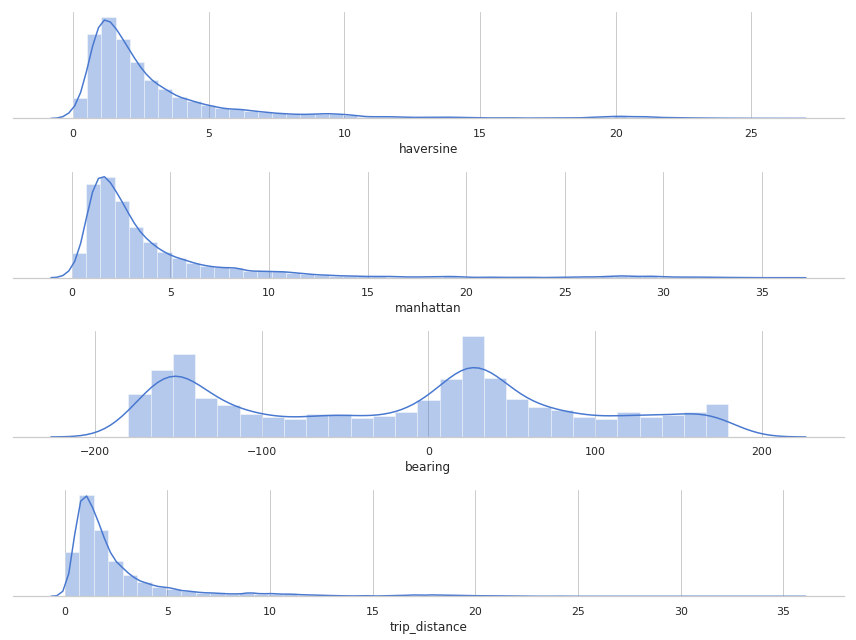

In [35]:
fig, axes = plt.subplots(4, 1, figsize=(12, 9))
sns.distplot(train_df['haversine'], ax=axes[0], axlabel='haversine');
sns.distplot(train_df['manhattan'], ax=axes[1], axlabel='manhattan');
sns.distplot(train_df['bearing'], ax=axes[2], axlabel='bearing');
sns.distplot(train_df['trip_distance'], ax=axes[3], axlabel='trip_distance');

sns.despine(left=True);
plt.setp(axes, yticks=[]);
plt.tight_layout();


### Question 6a

The `bearing` direction is angle, the initial direction of the trip.  
The bearing direction has two prominent peaks around 30 and -150 degrees.  
**Can you relate these peaks to the orientation of Manhattan? What do you notice about these angles?**

**Hint:** This [wikipedia article](https://en.wikipedia.org/wiki/Commissioners%27_Plan_of_1811) has the answer, although it may take some digging. Alternatively, try to look at a map of Manhattan.

In [36]:
q6a_answer = r"""

The bearing direction is an angle that is the initial direction of the trip, with prominent peaks around 30 and -150
degrees. We are able to relate this to the orientation of Manhattan. These angles represent the grid of Manhattan, which
is not a square grid, the streets running river to river instead of uptown and down. The grid, or avenues of Manhattan,
sits at a twenty-nine-degree angle (approx. 30 degrees) off of true north, meaning that potentially every building on every 
street can receive direct daylight every day of the year. The grid has 12 primary north–south avenues and numerous cross 
streets arranged in a regular right-angled grid tilted 29 degrees east of true north to roughly replicate the angle of 
Manhattan Island. Essentially, the prominent peak bearing angles give us the direction of Manhattan respective to the 
clockwise direction from the north line, which are 30 and -150 degrees. What I notice about these angles is that on the 
bearings compass they are directly accross from each other. 

"""


#raise NotImplementedError()

print(q6a_answer)



The bearing direction is an angle that is the initial direction of the trip, with prominent peaks around 30 and -150
degrees. We are able to relate this to the orientation of Manhattan. These angles represent the grid of Manhattan, which
is not a square grid, the streets running river to river instead of uptown and down. The grid, or avenues of Manhattan,
sits at a twenty-nine-degree angle (approx. 30 degrees) off of true north, meaning that potentially every building on every 
street can receive direct daylight every day of the year. The grid has 12 primary north–south avenues and numerous cross 
streets arranged in a regular right-angled grid tilted 29 degrees east of true north to roughly replicate the angle of 
Manhattan Island. Essentially, the prominent peak bearing angles give us the direction of Manhattan respective to the 
clockwise direction from the north line, which are 30 and -150 degrees. What I notice about these angles is that on the 
bearings compass they are directl

### Question 6b

For haversine and manhattan distances, it is probably more helpful to look at the log distribution. We are also curious about whether these distance features can help us understand duration. Create at least one plot that compares haversine and manhattan distances and gives insight as to whether this would be a useful feature in our model.

In [37]:
train_df.head()

,record_id,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,...,duration,month,week_of_year,day_of_month,day_of_week,hour,week_hour,manhattan,bearing,haversine
16434,8614300,2,2016-01-21 17:37:12,2016-01-21 18:37:56,2,10.89,-73.863403,40.769432,1,N,...,3644.0,1,3,21,3,17,89,18.337393,-134.089374,12.972024
21929,7230200,2,2016-01-29 23:22:26,2016-01-29 23:31:23,2,1.00,-74.008087,40.739365,1,N,...,537.0,1,4,29,4,23,119,1.614096,156.337415,1.225374
3370,9830300,2,2016-01-05 18:50:16,2016-01-05 18:56:00,2,0.56,-73.972923,40.755650,1,N,...,344.0,1,1,5,1,18,42,0.950307,63.789793,0.709796
21975,7251500,2,2016-01-30 00:14:34,2016-01-30 00:47:13,1,6.65,-73.992027,40.718662,1,N,...,1959.0,1,4,30,5,0,120,11.674355,140.462050,8.294571
13758,6168000,1,2016-01-18 13:25:24,2016-01-18 13:38:51,1,2.10,-73.953125,40.784538,1,N,...,807.0,1,3,18,0,13,13,3.961796,-153.407298,2.952737


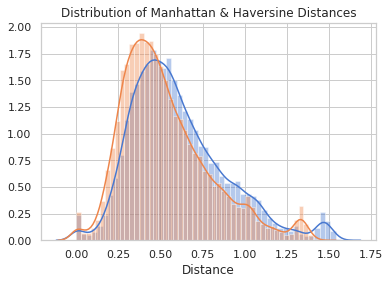

In [39]:
# Visualization (at least one plot)

sns.distplot(np.log10(train_df['manhattan'].values + 1))
sns.distplot(np.log10(train_df['haversine'].values + 1)) 

plt.title('Distribution of Manhattan & Haversine Distances')
plt.xlabel("Distance");

#raise NotImplementedError()

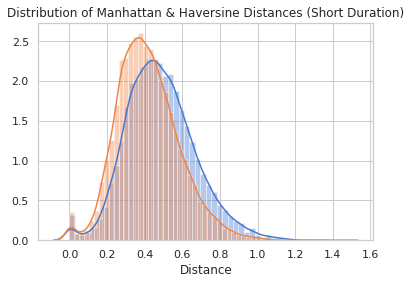

In [42]:
sns.distplot(np.log10(short_rides['manhattan'].values + 1))
sns.distplot(np.log10(short_rides['haversine'].values + 1)) 

plt.title('Distribution of Manhattan & Haversine Distances (Short Duration)')
plt.xlabel("Distance");

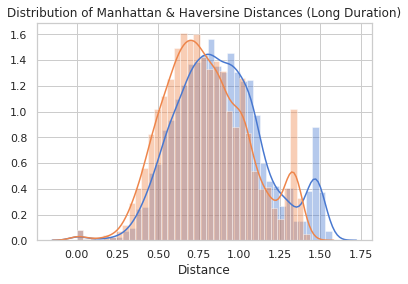

In [43]:
sns.distplot(np.log10(long_rides['manhattan'].values + 1))
sns.distplot(np.log10(long_rides['haversine'].values + 1)) 

plt.title('Distribution of Manhattan & Haversine Distances (Long Duration)')
plt.xlabel("Distance");

### Question 6c
Justify why you chose this visualization method and how it helps inform you about using manhattan/haversine distance as a feature for predicting trip duration.

In [44]:
q6c_answer = r"""

I chose a distribution plot to visualize the distribution of manhattan and haversine distances individually and together.
This allows us to view their individual distributions, as well as compare the two distance distributions to each other.
The blue distribution is the manhattan distance and the orange distribution is the haversine distance. From this visualization,
we are able to see the difference between the two distance distributions in one plot, which helps us determine if further examining
and analyzing these distributions will be helpful in predicting trip duration. What we notice is that there is some difference
between the two distances, so further examining manhattan distance and haversine distance in regards to distribution may be helpful
for future analysis. 

Dividing the plots into short duration and long duration shows us that this distance feature is still helpful for our model
as there is a difference between haversine and manhattan with respect to the trip duration. We see that there is a larger
distance for longer trips, which makes sense. 

"""


#raise NotImplementedError()

print(q6c_answer)



I chose a distribution plot to visualize the distribution of manhattan and haversine distances individually and together.
This allows us to view their individual distributions, as well as compare the two distance distributions to each other.
The blue distribution is the manhattan distance and the orange distribution is the haversine distance. From this visualization,
we are able to see the difference between the two distance distributions in one plot, which helps us determine if further examining
and analyzing these distributions will be helpful in predicting trip duration. What we notice is that there is some difference
between the two distances, so further examining manhattan distance and haversine distance in regards to distribution may be helpful
for future analysis. 

Dividing the plots into short duration and long duration shows us that this distance feature is still helpful for our model
as there is a difference between haversine and manhattan with respect to the trip duration

### Question 6d
Fill in the code below to plot a scatter plot of manhattan distance vs duration.

In [45]:
train_df.head()

,record_id,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,...,duration,month,week_of_year,day_of_month,day_of_week,hour,week_hour,manhattan,bearing,haversine
16434,8614300,2,2016-01-21 17:37:12,2016-01-21 18:37:56,2,10.89,-73.863403,40.769432,1,N,...,3644.0,1,3,21,3,17,89,18.337393,-134.089374,12.972024
21929,7230200,2,2016-01-29 23:22:26,2016-01-29 23:31:23,2,1.00,-74.008087,40.739365,1,N,...,537.0,1,4,29,4,23,119,1.614096,156.337415,1.225374
3370,9830300,2,2016-01-05 18:50:16,2016-01-05 18:56:00,2,0.56,-73.972923,40.755650,1,N,...,344.0,1,1,5,1,18,42,0.950307,63.789793,0.709796
21975,7251500,2,2016-01-30 00:14:34,2016-01-30 00:47:13,1,6.65,-73.992027,40.718662,1,N,...,1959.0,1,4,30,5,0,120,11.674355,140.462050,8.294571
13758,6168000,1,2016-01-18 13:25:24,2016-01-18 13:38:51,1,2.10,-73.953125,40.784538,1,N,...,807.0,1,3,18,0,13,13,3.961796,-153.407298,2.952737


/srv/conda/envs/data100/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


Text(0,0.5,'Duration')

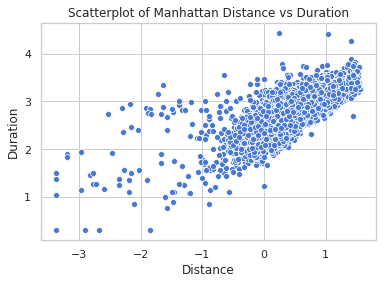

In [46]:
#I take np.log10 because without it, it's hard to properly see the scatterplot. I learned this from previous lectures and labs.
sns.scatterplot(x = np.log10(train_df['manhattan'].values), y = np.log10(train_df['duration'].values))

plt.title('Scatterplot of Manhattan Distance vs Duration')
plt.xlabel('Distance')
plt.ylabel('Duration')

#raise NotImplementedError()

### Question 6e

According to the plot above, there are a few outliers in both duration and manhattan distance. **Which type of outliers is most likely to be a mistake in our data?**

In [47]:
q6e_answer = r"""

The type of outliers most likeley to be a mistake in our data is due to human error. We can see this by the fact that
there are many rides lasting over 4 hours, but we know the average ride to be 2 hours. Therefore, showing that there is 
likeley human error for these types of outliers. 

"""

#raise NotImplementedError()

print(q6e_answer)



The type of outliers most likeley to be a mistake in our data is due to human error. We can see this by the fact that
there are many rides lasting over 4 hours, but we know the average ride to be 2 hours. Therefore, showing that there is 
likeley human error for these types of outliers. 




## 7: Advanced features
You do not need to incorporate these features into your model, although it may help lower your error. You are required to read through this portion and respond to the questions. All of the code is provided, please skim through it and try to understand what each cell is doing.

### Clustering
[Clustering](https://en.wikipedia.org/wiki/Cluster_analysis) is the task of grouping objects such that members within each group are more similar to each other than members of other groups. Clustering is a powerful tool used in many fields, including machine learning, pattern recognition, image analysis, information retrieval, bioinformatics, data compression, and computer graphics. Recall cluster sampling, which we learned earlier in the semester. We will use a simple clustering method (clustering by spatial locality) to reveal some more advanced features.

### Speed features

For `train_df`, we have the `duration` and now some distance information.  
This is enough for us to compute average speed and try to better understand our data.   

For `test_df`, we cannot use `duration` as a feature because it is what we are trying to predict. One clever way to include speed information for modeling would be as follows:

1. Cluster the observations in `train_df` by rounding the latitude and longitudes.
2. Compute the average speed per pickup cluster and dropoff cluster.
3. Match each observation in `test_df` to its pickup cluster and dropoff cluster based off the latitude and longitude, thus assigning the average speed for the pickup and dropoff cluster.
4. We have added speed information as features for `test_df`.

Therefore, we have propagated information computed in the `train_df` into the `test_df` via clustering. This is not something we will do in this notebook, although you can try it for yourself!

Other information that could be added based on clustering (both pickup cluster and dropoff cluster):
- Average of `avg_speed_h` per cluster.
- Average of `duration` per cluster.
- Average of `avg_speed_h` per cluster and hour.
- Average of `duration` per cluster and hour.
- In-cluster flow of trips for 60 min period.
- Out-cluster flow of trips for 60 min period.

In [48]:
# Calculate average manhattan speed
train_df['avg_speed_m'] = 1000 * train_df['manhattan'] / train_df['duration']
train_df['avg_speed_m'] = train_df['avg_speed_m'][train_df['avg_speed_m'] < 100]
train_df['avg_speed_m'].fillna(train_df['avg_speed_m'].median(), inplace=True)

In [49]:
train_df['avg_speed_m'].describe()

count    18354.000000
mean         5.210825
std          2.883174
min          0.000000
25%          3.287328
50%          4.617264
75%          6.413992
max         59.225577
Name: avg_speed_m, dtype: float64

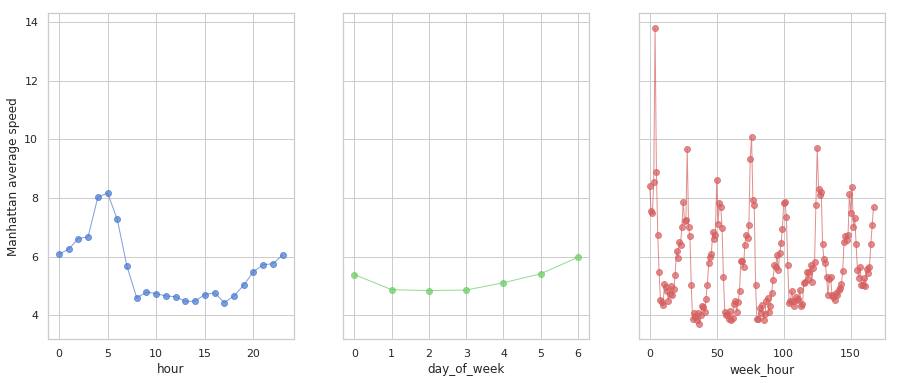

In [50]:
# Visualize average manhattan speed by hour, day of week and week hour
fig, axes = plt.subplots(ncols=3, figsize=(15, 6), sharey=True)

axes[0].plot(train_df.groupby('hour').mean()['avg_speed_m'], 'bo-', lw=1, alpha=0.7)
axes[1].plot(train_df.groupby('day_of_week').mean()['avg_speed_m'], 'go-', lw=1, alpha=0.7)
axes[2].plot(train_df.groupby('week_hour').mean()['avg_speed_m'], 'ro-', lw=1, alpha=0.7)

axes[0].set_xlabel('hour')
axes[1].set_xlabel('day_of_week')
axes[2].set_xlabel('week_hour')
axes[0].set_ylabel('Manhattan average speed');

### Question 7a
Based off of these visualizations, provide 2-3 insights on the average speed.

In [51]:
q7a_answer = r"""

The visualizations above show the average speed in Manhattan based on hour of the day, day of the week, and hour of the week.
From the first plot, we see that the peak (highest average speed) is 8 around hour 5 (5am). After that peak, the average
speed decreases to about hour 8 (8am) and is fairly steady until the speed increases again around hour 17 (5pm). We can
conclude from this that in Manhattan, the average speed stays around 5 during the daytime / working hours (hours 8 - 17,8am - 5pm) 
while the average speed increases after hours and early in the morning (after 5pm and before 8am). 

From the second plot, we see that the average speed is fairly steady / consistent during the work week (Monday through Thursday),
at speed 5, with increase in speed on the weekend (Friday through Sunday) ranging up to speed 6. This validates our conclusion
from the first plot above where we inspected hour. 

From the third plot, we see that there is a pattern / trend in average speed for each hour of the week. This pattern 
follows a seasonal trend, with the highest average speed around week_hour 0. Besides that, the range of the seasonal 
pattern average speed is from a little under speed 4 to a little above speed 10 (besides the peak of the entire plot at 
about speed 14 for week_hour 0). 

Comparing all three plots, we see that though they are measuring different temporal features, they show a similar trend for average
speed, and all confirm each oterhs' conclusions. 

"""

#raise NotImplementedError()

print(q7a_answer)



The visualizations above show the average speed in Manhattan based on hour of the day, day of the week, and hour of the week.
From the first plot, we see that the peak (highest average speed) is 8 around hour 5 (5am). After that peak, the average
speed decreases to about hour 8 (8am) and is fairly steady until the speed increases again around hour 17 (5pm). We can
conclude from this that in Manhattan, the average speed stays around 5 during the daytime / working hours (hours 8 - 17,8am - 5pm) 
while the average speed increases after hours and early in the morning (after 5pm and before 8am). 

From the second plot, we see that the average speed is fairly steady / consistent during the work week (Monday through Thursday),
at speed 5, with increase in speed on the weekend (Friday through Sunday) ranging up to speed 6. This validates our conclusion
from the first plot above where we inspected hour. 

From the third plot, we see that there is a pattern / trend in average speed for each ho

We are now going to visualize the average speed per region. Here we define regions as a very basic classical clustering based on rounding of spatial coordinates.

In [52]:
# Round / bin the latitude and longitudes
train_df['start_lat_bin'] = np.round(train_df['pickup_latitude'], 3)
train_df['start_lng_bin'] = np.round(train_df['pickup_longitude'], 3)

# Average speed for regions
gby_cols = ['start_lat_bin', 'start_lng_bin']

coord_stats = (train_df.groupby(gby_cols)
               .agg({'avg_speed_m': 'mean', 'manhattan': 'count'})
               .reset_index())

coord_stats = coord_stats[coord_stats['manhattan'] > 10]

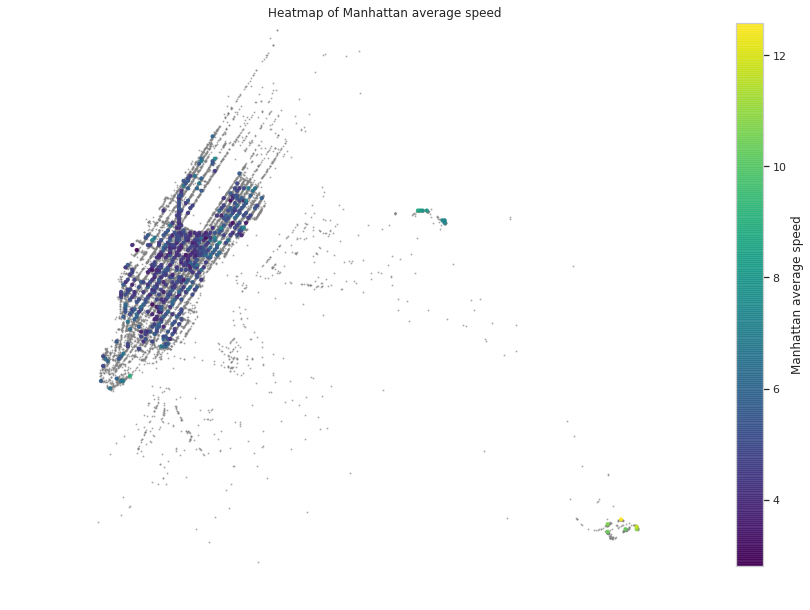

In [53]:
# Visualize the average speed per region
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(14, 10))

scatter_trips = ax.scatter(train_df['pickup_longitude'].values,
                           train_df['pickup_latitude'].values,
                           color='grey', s=1, alpha=0.5)

scatter_cmap = ax.scatter(coord_stats['start_lng_bin'].values,
                          coord_stats['start_lat_bin'].values,
                          c=coord_stats['avg_speed_m'].values,
                          cmap='viridis', s=10, alpha=0.9)

cbar = fig.colorbar(scatter_cmap)
cbar.set_label("Manhattan average speed")
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.title('Heatmap of Manhattan average speed')
plt.axis('off');

### Question 7b
In 2-3 sentences, describe how we can use the clustering visualization above to gain insight on the speed. Do you think spatial clustering would be useful in reducing the error of our model?

In [54]:
q7b_answer = r"""

The clustering visualization, or heatmap, above shows a spatial map of NY and LaGuardia (and other islands), color coded according to
the color bar on the right-hand side of the plot which represents the Manhattan average speed. This is a great visualization
that helps us see where in Manhattan and LaGuardia there is a low average speed (purple), medium average speed (teal to green),
and there is a high average speed (green to yellow). This color coding and heatmap, helps us to see which neighborhoods,
streets, and avenues of NY have low to high average speed of rides. 

Due to the effectiveness of the clustering visualization in understanding our data better, I do believe spatial clustering
would be very useful in reducing the error of our model. Especially, if we partner it up with other visualizations similar 
to the plots we made above. Doing this would provide us, data scientists, with the opportunity to visually see where we 
may have gone wrong in our analysis or where in our data there may be inaccurate information. 

"""

#raise NotImplementedError()

print(q7b_answer)



The clustering visualization, or heatmap, above shows a spatial map of NY and LaGuardia (and other islands), color coded according to
the color bar on the right-hand side of the plot which represents the Manhattan average speed. This is a great visualization
that helps us see where in Manhattan and LaGuardia there is a low average speed (purple), medium average speed (teal to green),
and there is a high average speed (green to yellow). This color coding and heatmap, helps us to see which neighborhoods,
streets, and avenues of NY have low to high average speed of rides. 

Due to the effectiveness of the clustering visualization in understanding our data better, I do believe spatial clustering
would be very useful in reducing the error of our model. Especially, if we partner it up with other visualizations similar 
to the plots we made above. Doing this would provide us, data scientists, with the opportunity to visually see where we 
may have gone wrong in our analysis or where in our 

## Part 2 Exports
We are not requiring you to export anything from this notebook, but you may find it useful to do so. There is a space below for you to export anything you wish.

In [55]:
Path("data/part2").mkdir(parents=True, exist_ok=True)
data_file = Path("data/part2", "data_part2.hdf") # Path of hdf file
...

Ellipsis

## Part 2 Conclusions 

We now have a good understanding of the taxi data we are working with.
Visualizing large amounts of data can be a difficult task. One helpful tool is [datashader](https://github.com/bokeh/datashader), a data rasterization pipeline for automating the process of creating meaningful representations of large amounts of data. Using the [geopandas](http://geopandas.org/) package also makes working with geospatial data easier. We encourage you to explore these tools if you are interested in learning more about visualization!

Within our taxi data set, we have explored different features and their relationship with ride duration. Now, we are ready to incorporate more data in order to add to our set of features.

**Please proceed to part 3 where we will be engineering more features and building our models using a processing pipeline.**

## Submission

You're almost done!

Before submitting this assignment, ensure that you have:

1. Restarted the Kernel (in the menubar, select Kernel$\rightarrow$Restart & Run All)
2. Validated the notebook by clicking the "Validate" button.

Then,

1. **Submit** the assignment via the Assignments tab in **Datahub** 
1. **Upload and tag** the manually reviewed portions of the assignment on **Gradescope**